## AllLife Bank Customer Segmentation

### Context
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help

 

### Objective
To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

 

### Data Description
The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

### Data Dictionary

- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of Visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

### Importing necessary libraries

In [22]:
%load_ext nb_black
# this will help in making the Python code more structured automatically

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


# to compute distances
from scipy.spatial.distance import cdist,pdist

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to perform PCA
from sklearn.decomposition import PCA

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [23]:
# loading the dataset
data = pd.read_excel("Credit Card Customer Data.xlsx")

<IPython.core.display.Javascript object>

In [24]:
data.shape

(660, 7)

<IPython.core.display.Javascript object>

* Dataset has 660 rows and 7 columns

In [25]:
# viewing a random sample of the dataset
data.sample(n=10, random_state=1)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
547,548,38125,26000,4,5,2,4
353,354,94437,9000,5,4,1,3
499,500,65825,68000,6,4,2,2
173,174,38410,9000,2,1,5,8
241,242,81878,10000,4,5,1,3
341,342,70779,18000,4,3,2,0
647,648,79953,183000,9,0,9,2
218,219,28208,19000,3,1,5,7
120,121,16577,10000,4,2,4,6
134,135,31256,13000,4,1,5,7


<IPython.core.display.Javascript object>

* 7 rows are observed as expected
* Customer Key is missing an underscore(_). We will need to fix that to "customer_key"

In [26]:
# copying the data to another variable to avoid any changes to original data
c_data = data.copy()

<IPython.core.display.Javascript object>

In [27]:
# checking datatypes and number of non-null values for each column
c_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


<IPython.core.display.Javascript object>

* there are no missing values
* All Dtypes are integer types as they should be, thus we can proceed.

In [28]:
# Let's look at the statistical summary of the data
c_data.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


<IPython.core.display.Javascript object>

* We notice a big difference between maximum Average Credit Limit and the Median. This is an indication of extreme right skew and also of outliers as is typically the case of credit records. 
* Average Total_Credit_Cards is ~4
* There are customers who have never visited the bank in a year meaning they are most likely using the bank's virtual or online resources.
* There are customers who have never visited online. This could mean they prefer physical visits.
* The average bank visits and online visits are close

In [29]:
#before we proceed, let us replace the space between customer Key with underscore
c_data.columns = [c.replace(" ", "_") for c in c_data.columns]

<IPython.core.display.Javascript object>

In [30]:
# checking the number of unique values
c_data.nunique()

Sl_No                  660
Customer_Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

<IPython.core.display.Javascript object>

* There is a mismatch between 'Sl_No' and 'Customer_Key' but we will not be concerned about that as those two columns are irrelevant to our data analysis and will be dropped. 

In [31]:
#dropping columns "Sl_No" and "Customer_Key"
c_data.drop(columns=["Sl_No"], inplace=True)
c_data.drop(columns=["Customer_Key"], inplace=True)

<IPython.core.display.Javascript object>

In [32]:
#Reading the first 5 rows of the data
c_data.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


<IPython.core.display.Javascript object>

## EDA

## Univariate Analysis

In [33]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

<IPython.core.display.Javascript object>

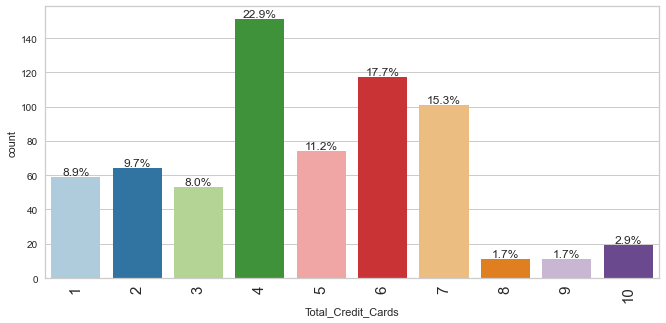

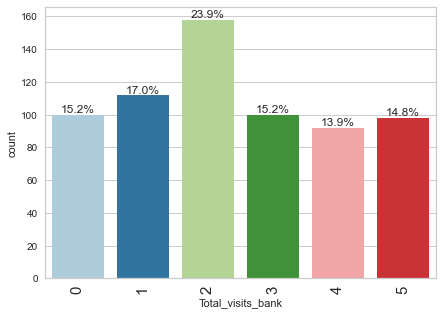

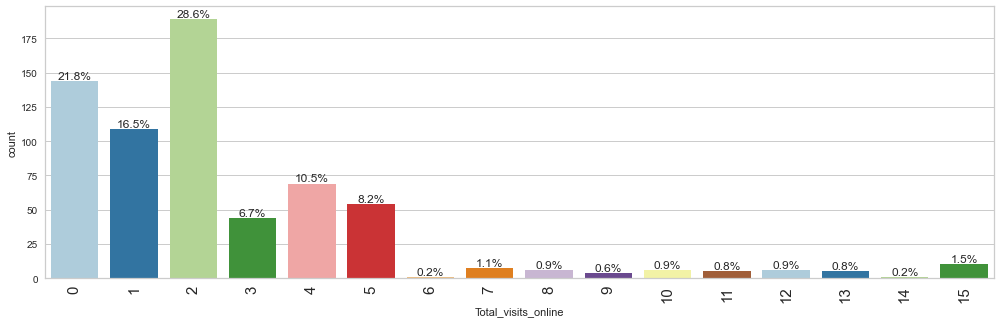

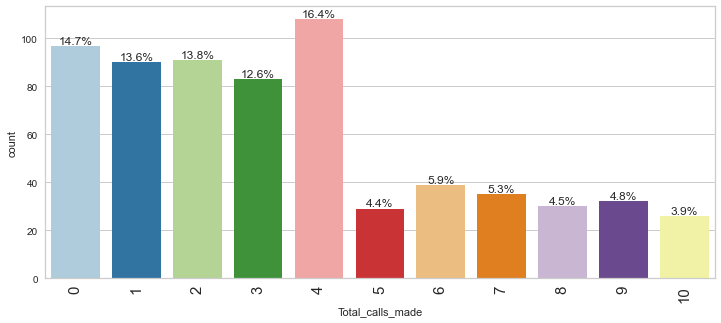

<IPython.core.display.Javascript object>

In [34]:
for col in c_data.columns.tolist()[1:]:
    labeled_barplot(c_data, col, perc=True)

#### Observation:
* ~ 67% of customers hold 4-7 credit cards
* very low percentage of customers have more than 7 credit cards
* ~85% of customers have visited the bank at least once within the year
* 21.8% of customers never used the Bank's online service
* 85.3% of customers have made a call to the bank, while 14.7% have not

In [35]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

<IPython.core.display.Javascript object>

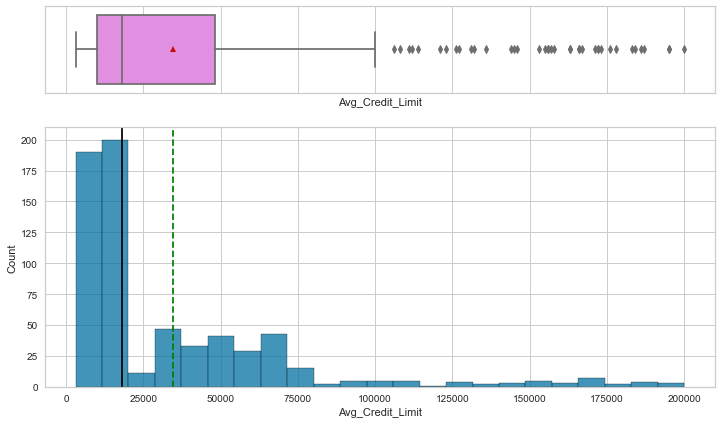

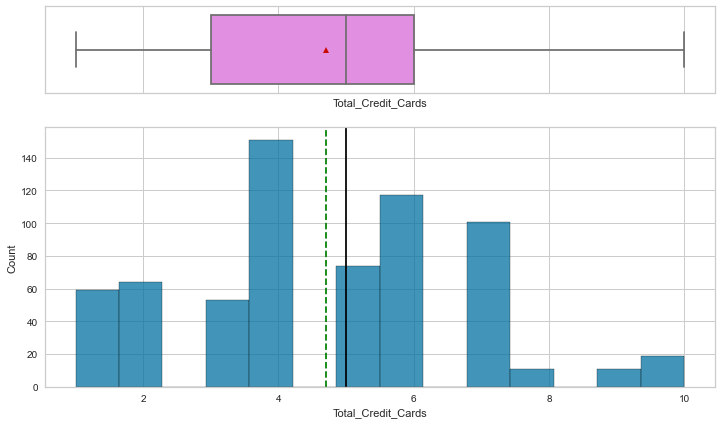

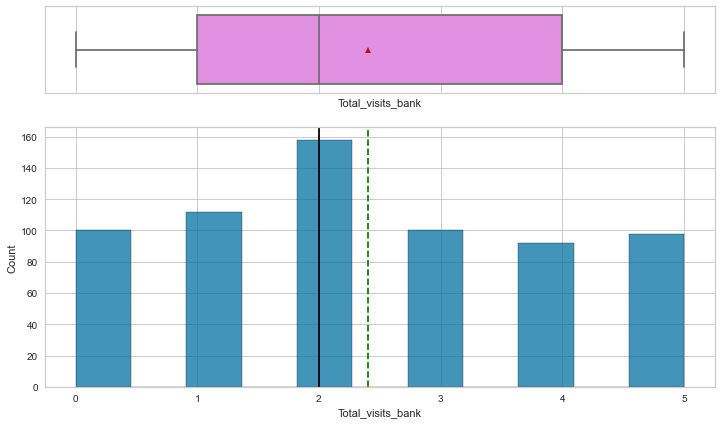

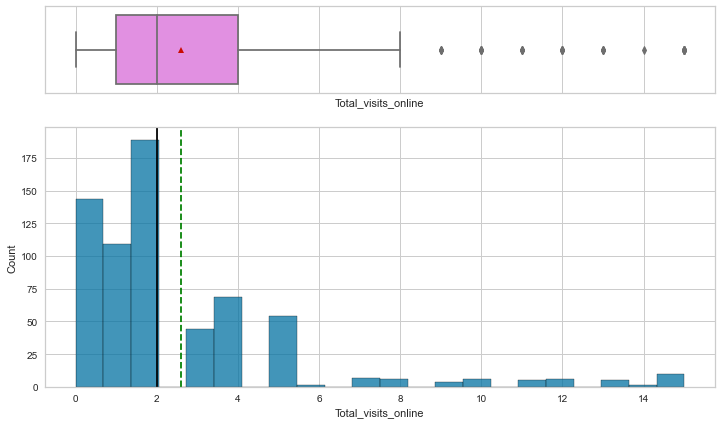

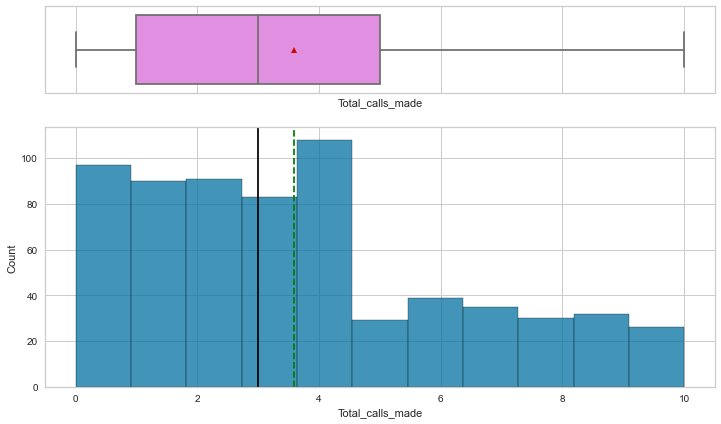

<IPython.core.display.Javascript object>

In [36]:
for col in c_data.columns:
    histogram_boxplot(data, col)

#### Observation:
* Avg_credit_limit is extremely right skewed and has many outliers. 
* Total_visits_online is right skewed with a few outliers.
* Total_visits_bank is uniform; and shows that majority of the customers made 2 visits to the bank. 
* Total_credit_cards is almost uniform and shows majority of customers having 4 cards. 

### Bivariate Analysis

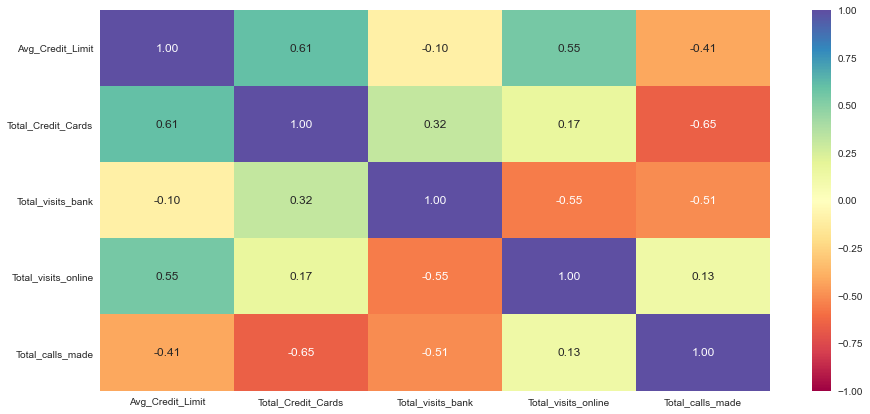

<IPython.core.display.Javascript object>

In [37]:
plt.figure(figsize=(15, 7))
sns.heatmap(c_data.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

* There is a somewhat strong positive correlation between Total_Credit_Cards and Average_Credit_Limit. This could imply that credit limits increases with increasing credit cards. 
* there is also a slight positive correlation between Avg_Credit_Limit and the Total_visits_online.
* Total_Credit_Cards and Total_calls_made has a strong negative correlation.

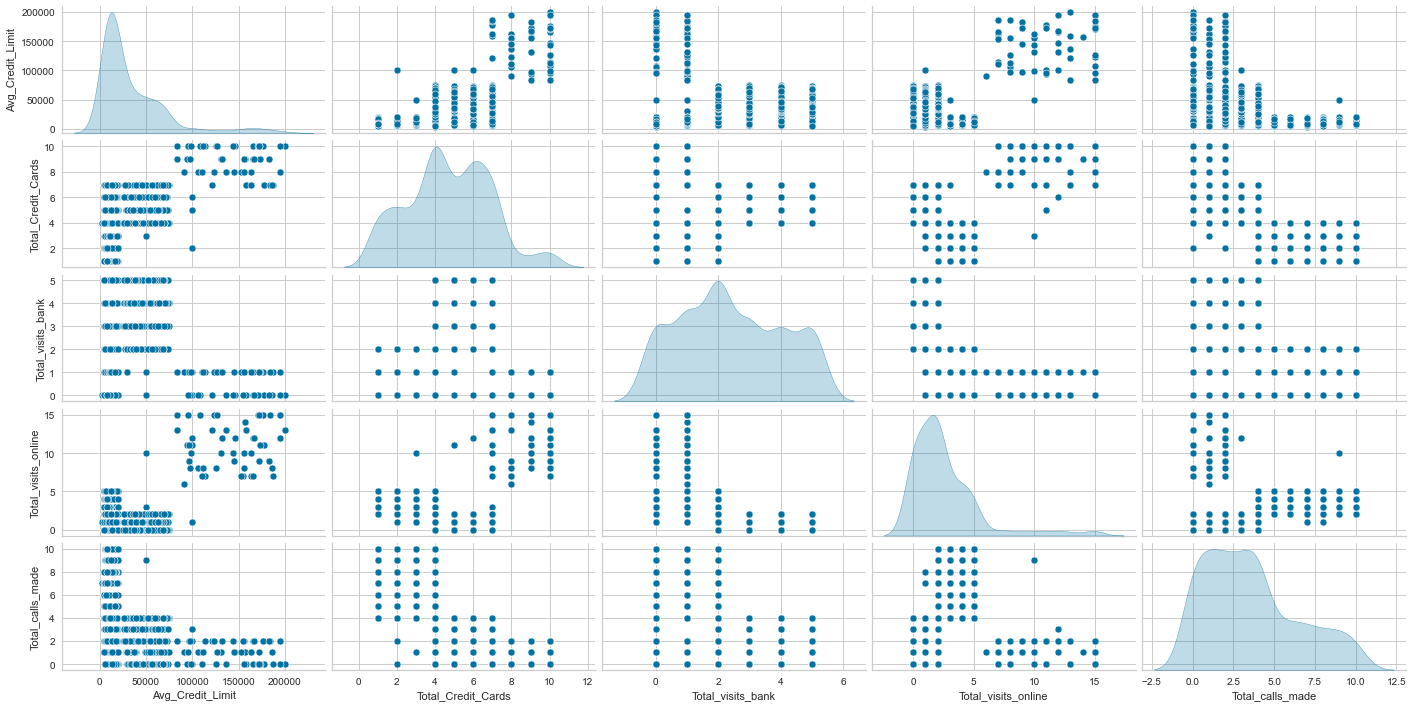

<IPython.core.display.Javascript object>

In [38]:
#Let's see if we can observe some clusters
sns.pairplot(c_data, height=2,aspect=2 , diag_kind='kde')

* Clustering is prominent in "Total_Credit_Cards"

#### Let's use 3D to explore clustering based on means of contacting the Bank.

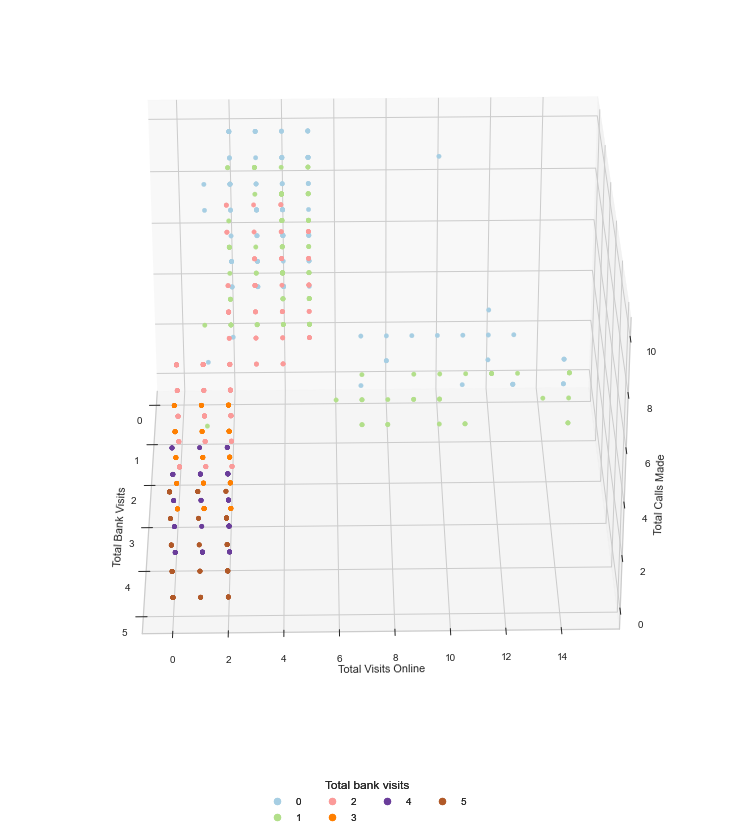

<IPython.core.display.Javascript object>

In [39]:
# using code inspired by http://blog.mahler83.net/2019/10/rotating-3d-t-sne-animated-gif-scatterplot-with-matplotlib/

from mpl_toolkits.mplot3d import axes3d, Axes3D

fig = plt.figure(figsize=(10,10))

ax = Axes3D(fig)



x = c_data.Total_visits_bank
y = c_data.Total_visits_online
z = c_data.Total_calls_made


g = ax.scatter(x, y, z, c=x, marker='o', depthshade=False, cmap='Paired')
ax.set_xlabel('Total Bank Visits')
ax.set_ylabel('Total Visits Online')
ax.set_zlabel('Total Calls Made')

# produce a legend with the unique colors from the scatter
legend = ax.legend(*g.legend_elements(), loc="lower center", title="Total bank visits", borderaxespad=-10, ncol=4)
ax.add_artist(legend)

# plt.show()
from matplotlib import animation

def rotate(angle):
     ax.view_init(azim=angle)

angle = 1
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=1)
ani.save('Cluster_plot.gif', writer=animation.PillowWriter(fps=25));


* we can observe clustering based on means of contacting the bank.

#### Let's scale the data before we proceed to cluster it.

In [40]:
sc = StandardScaler()
subset=c_data.copy()
subset_scaled_df = pd.DataFrame(
    sc.fit_transform(subset),
    columns=subset.columns,
)
subset_scaled_df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739


<IPython.core.display.Javascript object>

### K-Means Clustering

In [41]:
k_means_df = subset_scaled_df.copy()

<IPython.core.display.Javascript object>

Number of Clusters: 1 	Average Distortion: 2.0069222262503614
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.990772333470802
Number of Clusters: 6 	Average Distortion: 0.9429939411157943
Number of Clusters: 7 	Average Distortion: 0.9106714901718491
Number of Clusters: 8 	Average Distortion: 0.8905255696010017
Number of Clusters: 9 	Average Distortion: 0.8674445785315296


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

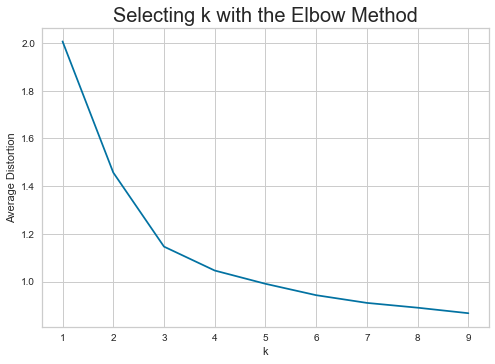

<IPython.core.display.Javascript object>

In [42]:
from sklearn.cluster import KMeans
clusters = range(1, 10)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction = model.predict(k_means_df)
    distortion = (
        sum(
            np.min(cdist(k_means_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / k_means_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)

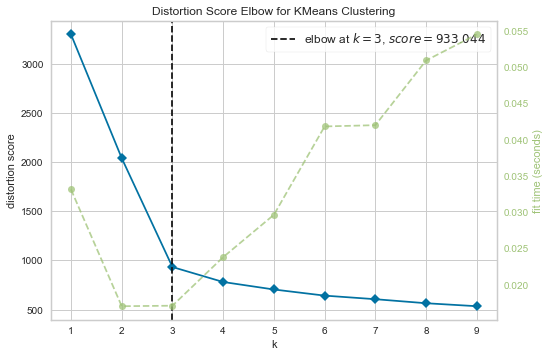

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

<IPython.core.display.Javascript object>

In [43]:
#Finding optimal no. of clusters with elbow method
visualizer = KElbowVisualizer(KMeans(), k=(1,10), timings = True, locate_elbow = True)
visualizer.fit(k_means_df) 
visualizer.show()

* The appropriate value of k from the elbow curve seems to be 3. 

#### Let's check the silhouette scores.

For n_clusters = 2, silhouette score is 0.41842496663215445
For n_clusters = 3, silhouette score is 0.5157182558881063
For n_clusters = 4, silhouette score is 0.3556670619372605
For n_clusters = 5, silhouette score is 0.2717470361089752
For n_clusters = 6, silhouette score is 0.2553480159463278
For n_clusters = 7, silhouette score is 0.2479168060842431
For n_clusters = 8, silhouette score is 0.22631767554074458
For n_clusters = 9, silhouette score is 0.21756148215272145


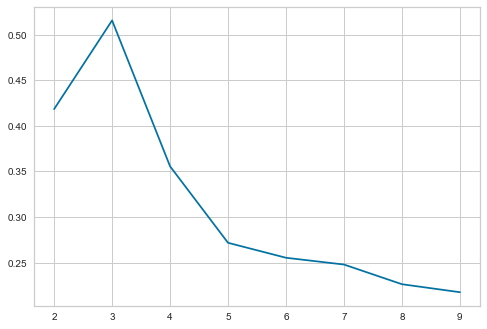

<IPython.core.display.Javascript object>

In [44]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((k_means_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(k_means_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)


* From the silhouette scores, it seems that 3 is a good value of k.

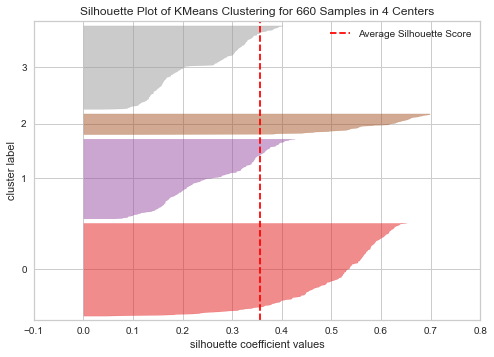

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [45]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(k_means_df)
visualizer.show()

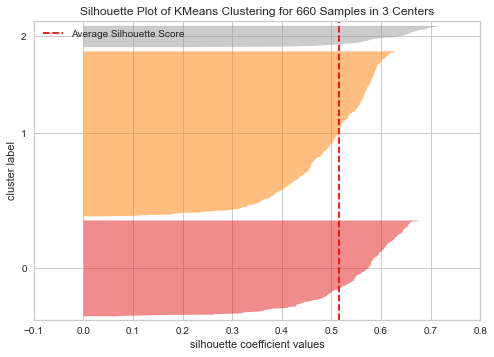

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [46]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(k_means_df)
visualizer.show()

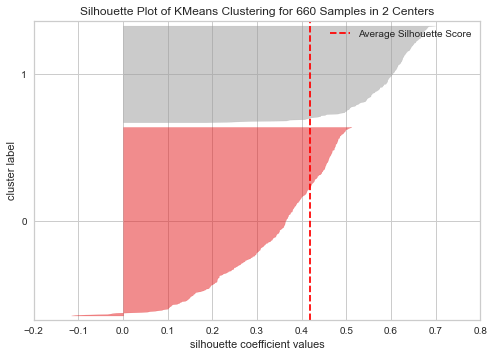

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [47]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(2, random_state=1))
visualizer.fit(k_means_df)
visualizer.show()

#### Let's proceed with cluster of 3 as Silhouette coffiecient is the highest plus its closer to the average score.

In [48]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(k_means_df)

KMeans(n_clusters=3, random_state=0)

<IPython.core.display.Javascript object>

In [49]:
#Let's create a copy of original data so it is saved for later use
#with hierarchical clustering
c_data1 = c_data
# adding kmeans cluster labels to the original dataframe
k_means_df["K_means_segments"] = kmeans.labels_
c_data1["K_means_segments"] = kmeans.labels_

<IPython.core.display.Javascript object>

### K-Means Cluster Profile

In [50]:
k_cluster_profile = c_data1.groupby("K_means_segments").mean()

<IPython.core.display.Javascript object>

In [51]:
k_cluster_profile["count_in_each_segment"] = (
    c_data1.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

<IPython.core.display.Javascript object>

In [52]:
# let's display cluster profiles
k_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,12174.107143,2.410714,0.933036,3.553571,6.870536,224
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


<IPython.core.display.Javascript object>

## Hierarchical Clustering

In [53]:
h_clust = subset_scaled_df.copy()

<IPython.core.display.Javascript object>

In [54]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(h_clust, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(h_clust))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7391220243806552.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8599730607972423.
Cophenetic correlation for Euclidean distance and average linkage is 0.8977080867389372.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8861746814895477.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7382354769296767.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8533474836336782.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8974159511838106.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8913624010768603.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7058064784553606.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.5422791209801747.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8326994115042134.
Cophenetic co

<IPython.core.display.Javascript object>

In [55]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with Euclidean distance and average linkage.


<IPython.core.display.Javascript object>

#### Exploring different linkage methods with Euclidean distance only.

In [56]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(h_clust, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(h_clust))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.7391220243806552.
Cophenetic correlation for complete linkage is 0.8599730607972423.
Cophenetic correlation for average linkage is 0.8977080867389372.
Cophenetic correlation for centroid linkage is 0.8939385846326323.
Cophenetic correlation for ward linkage is 0.7415156284827493.
Cophenetic correlation for weighted linkage is 0.8861746814895477.


<IPython.core.display.Javascript object>

In [57]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print()
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)


Highest cophenetic correlation is 0.8977080867389372, which is obtained with average linkage.


<IPython.core.display.Javascript object>

#### Cophenetic correlation is maximum with Euclidean distance and average linkage.

**Let's see the dendrograms for the different linkage methods.**

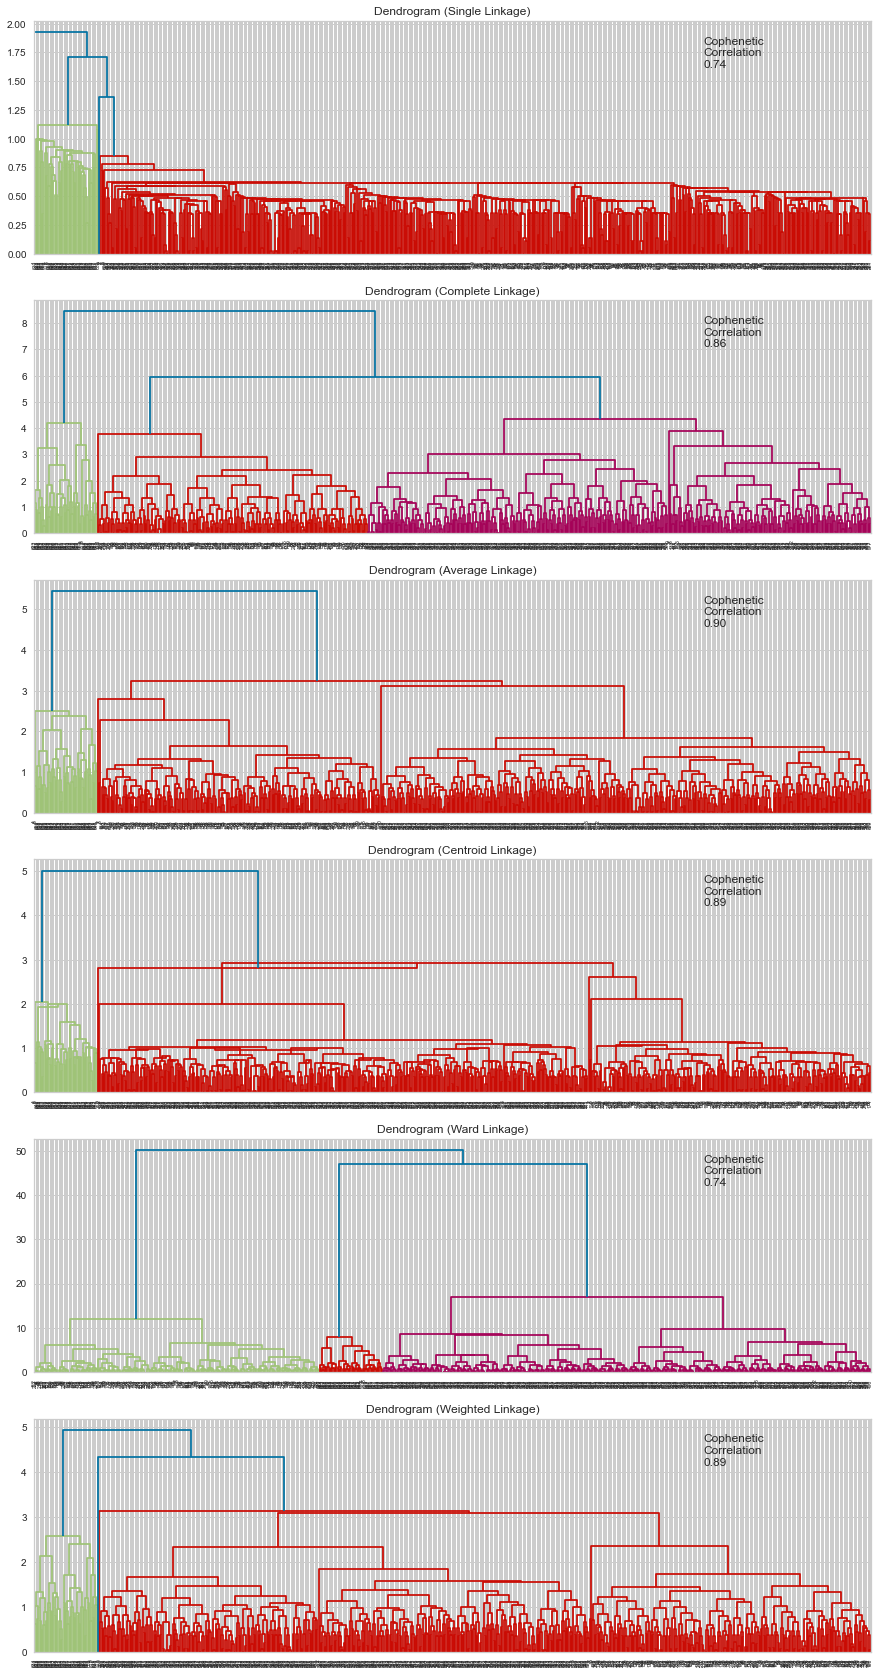

<IPython.core.display.Javascript object>

In [58]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(h_clust, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(h_clust))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

**Observations**

- The cophenetic correlation is highest for average linkage method.
- We will move ahead with average linkage.

In [59]:
#using 3 clusters, euclidean and average linkage
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="average")
HCmodel.fit(h_clust)

AgglomerativeClustering(linkage='average', n_clusters=3)

<IPython.core.display.Javascript object>

In [60]:
# creating a copy of the original data
c_data2 = c_data.copy()

# adding hierarchical cluster labels to the original and scaled dataframes
h_clust["HC_segments"] = HCmodel.labels_
c_data2["HC_segments"] = HCmodel.labels_

<IPython.core.display.Javascript object>

### Hierarchical Cluster Profile

In [61]:
H_cluster_profile = c_data2.groupby("HC_segments").mean()

<IPython.core.display.Javascript object>

In [62]:
# lets display cluster profile
H_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments
HC_segments,,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168,0.002584
1,141040.000000,8.740000,0.600000,10.900000,1.080000,2.000000
2,12197.309417,2.403587,0.928251,3.560538,6.883408,1.000000


<IPython.core.display.Javascript object>

### Comparing K-Means Clustering and Hierarchical Clustering 

In [63]:
k_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,12174.107143,2.410714,0.933036,3.553571,6.870536,224
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


<IPython.core.display.Javascript object>

In [64]:
H_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments
HC_segments,,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168,0.002584
1,141040.000000,8.740000,0.600000,10.900000,1.080000,2.000000
2,12197.309417,2.403587,0.928251,3.560538,6.883408,1.000000


<IPython.core.display.Javascript object>

#### Observations:

*  K-Means and Hierarchical clustering are very similar. It is observed that the striking difference is that Custer 1 of K-means is the same as Custer 2 of Hierarchical clustering and vice versa.
* In terms of excution time, it took longer to execute Hierarchical clustering than K-means clustering.

<AxesSubplot:xlabel='K_means_segments'>

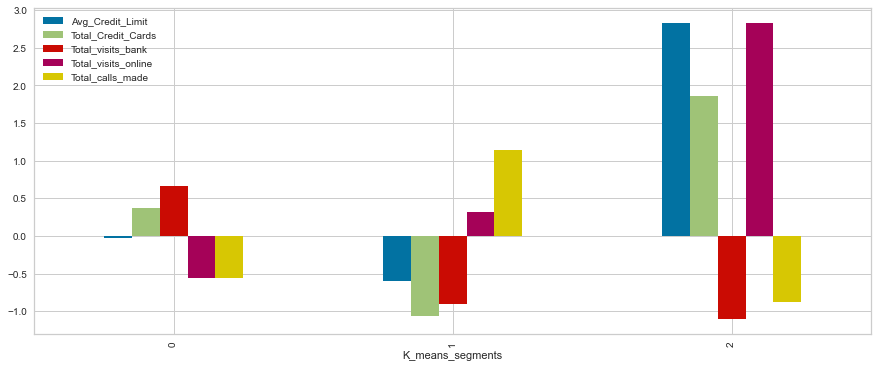

<IPython.core.display.Javascript object>

In [65]:
k_means_df.groupby("K_means_segments").mean().plot.bar(figsize=(15, 6))

<AxesSubplot:xlabel='HC_segments'>

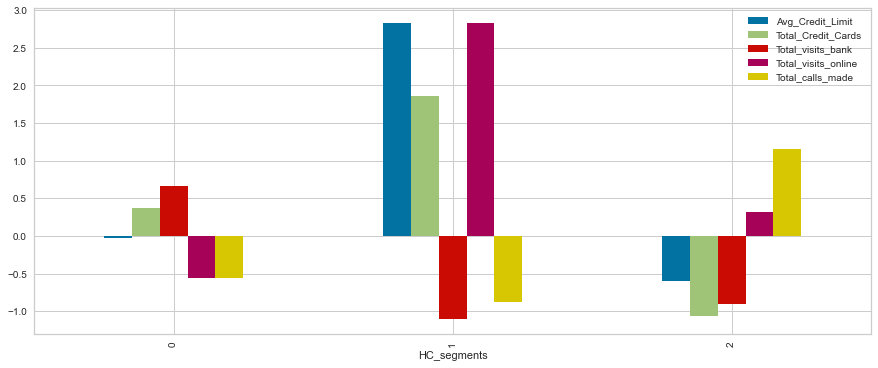

<IPython.core.display.Javascript object>

In [66]:
h_clust.groupby("HC_segments").mean().plot.bar(figsize=(15, 6))

* Chart shows the similarity between k-means and Hierarchical clustering only that cluster 1 and 2 are flipped. 

In [76]:
k_means_df.loc[k_means_df["K_means_segments"] == 1, "K_means_segments"] = 3
k_means_df.loc[k_means_df["K_means_segments"] == 2, "K_means_segments"] = 1
k_means_df.loc[k_means_df["K_means_segments"] == 3, "K_means_segments"] = 2
c_data1["K_means_segments"] = k_means_df["K_means_segments"]

km_cluster_profile = c_data1.groupby("K_means_segments").mean()
km_cluster_profile["count_in_each_segment"] = (
    c_data1.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

<IPython.core.display.Javascript object>

In [77]:
km_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,141040.000000,8.740000,0.600000,10.900000,1.080000,50
2,12174.107143,2.410714,0.933036,3.553571,6.870536,224


<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='K_means_segments'>

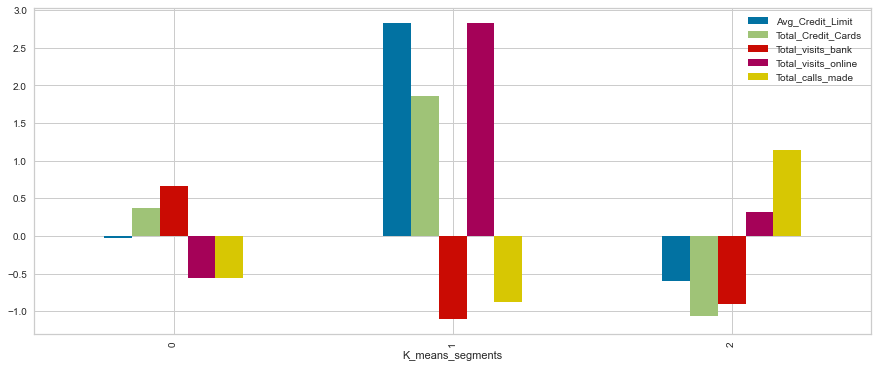

<IPython.core.display.Javascript object>

In [78]:
k_means_df.groupby("K_means_segments").mean().plot.bar(figsize=(15, 6))

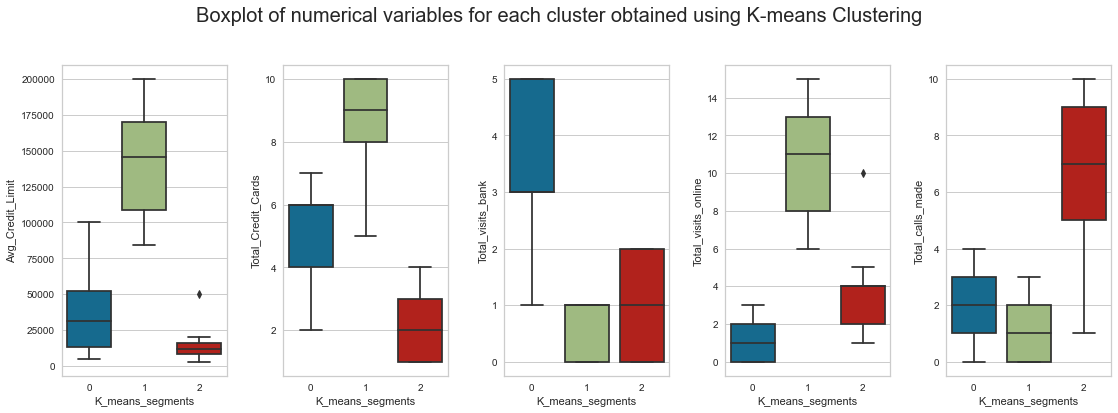

<IPython.core.display.Javascript object>

In [79]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle(
    "Boxplot of numerical variables for each cluster obtained using K-means Clustering",
    fontsize=20,
)

counter = 0

for ii in range(5):
    sns.boxplot(
        ax=axes[ii], y=c_data1[c_data1.columns[counter]], x=k_means_df["K_means_segments"]
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

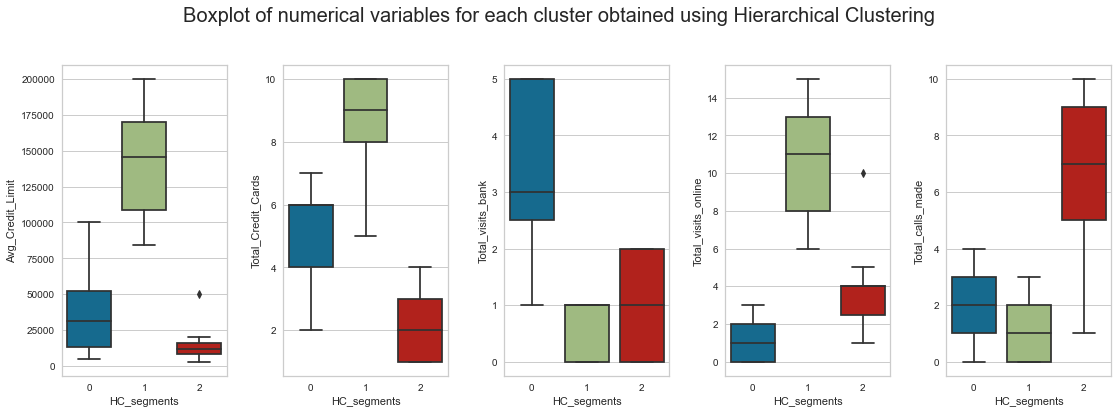

<IPython.core.display.Javascript object>

In [80]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle(
    "Boxplot of numerical variables for each cluster obtained using Hierarchical Clustering",
    fontsize=20,
)

counter = 0

for ii in range(5):
    sns.boxplot(ax=axes[ii], y=c_data2[c_data2.columns[counter]], x=h_clust["HC_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

### Insights

- **Cluster 0**:
    - Customers who have average credit limit between 20k and 100k and own credit cards 4-7 max.
    - Customers who most visited bank  2-5 times. It can be inferred that these customers prefer in person visits to online visits as seen in online visits below:
    - Customers who least visit bank online. (0-2 times)
    - Customers who make moderate phone calls (0-4 times)
    - Majority of customers are in this group - 58.4%.


- **Cluster 1**:
    - Customers who have average credit limit above 75k and own most credit cards 5-10 max.
    - These customers appear to be high spenders or premium users.
    - Customers who least visited bank 0-1 times.These customers mostly prefer to bank online 
    - Customers who most visit bank online . (6-15 times)
    - Customers who make least phone calls (0-2 times)
    - Only 7.3% of customers are in this group. 

- **Cluster 2**:
    - Customers who have average credit limit below 25k and own credit cards 1-4 max.
    - Customers who seldom visit bank 0-2 times.
    - Customers who visit bank online moderately (1-5 times)
    - Customers who make most phone calls (4-10 times). This certainly would require a lot of human resources from the bank.
    - 34% of customers are in this group.





## Business Recommendations

- Cluster 0  has an average credit limit and number of credit cards. This group constitutes more than half the customer base of the bank, and thus presents a great opportunity for the bank. Instead of focussing on recruiting new customers, the bank should focus the majority of its efforts on this group as it means less resources and potential increase in ROI. The bank can employ upselling to have these customers increase their credit limits to at least the level of the premium users. These customers make the least visit online so, the marketing department should communicate the benefits of online banking to them. 

- Cluster 1 appear to be high end users of credit cards but constitute a small percentage of the customer base. The bank can focus its efforts in recruiting customers with similar characteristics to these customers as they tend to spend more plus they do not require too much human resource in terms of customer service calls and inperson visits. 

- Cluster 2 has the lowest credit limit, which could mean they are low spenders.We found out that they make the most phone calls, meaning high cost of service or resolutions. The bank can upsell these customers to increase their credit limits and also in order to provide the proper and needed service to this group, the bank can conduct a survey over the phone to address what concerns them the most, and also train a dedicate resolutions team to handle their concerns. 